# Modeling

## Purpose
This notebook focuses on training and evaluating models to predict housing `median_price`. The workflow includes:
1. **Baseline Model**: Linear Regression using a simple train-test split.
2. **Advanced Model**: Random Forest with hyperparameter tuning using GridSearchCV and cross-validation.

---


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import joblib


## Load the Enhanced Dataset

The cleaned and feature-engineered dataset is loaded from the `data/processed/` folder for modeling.


In [4]:
file_path = '/Users/ebythomas/Documents/GitHub/Melbourne_Housing_Analytics/data/processed/enhanced_data.csv'
housing_data = pd.read_csv(file_path)

#Display dataset overview
housing_data.head()

,sale_year,median_price,transaction_count,type_encoded,small_area_encoded,rolling_avg_price,transaction_density
0,2000,316250.0,116,0,0,316250.0,0.016445
1,2000,220000.0,309,1,0,268125.0,0.043805
2,2000,622500.0,42,0,2,622500.0,0.010041
3,2000,295000.0,139,1,2,458750.0,0.033230
4,2000,215250.0,258,0,3,215250.0,0.043165


## Data Splitting

The dataset is split into training (80%) and test (20%) sets. The training set is used to train the models, while the test set evaluates their performance.


In [6]:
# Define features( X) and target (y)
y = housing_data['median_price']  # target variable
X = housing_data.drop(['median_price'],  axis =1) # features

#Split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=42)

print(f"Training set size :{X_train.shape[0]}")
print(f"Test set size : {X_test.shape[0]}")


Training set size :272
Test set size : 68


## Baseline Model: Linear Regression

Linear Regression is used as the baseline model. A simple train-test split is applied for evaluation. Metrics include:
- **Test RMSE**: Measures prediction error on the test set.
- **Test R²**: Proportion of variance explained by the model.


In [15]:
# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train,y_train)

# Make predictions
pred_test = lr.predict(X_test)

#Evalualte model
print("Linear Regression Performance:")
print(f"Test RMSE : {mean_squared_error(y_test, pred_test , squared = False):.2f}")
print(f"Test R² : {r2_score(y_test, pred_test):.2f}")


Linear Regression Performance:
Test RMSE : 276090.85
Test R² : 0.52


/usr/local/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Advanced Model: Random Forest with Hyperparameter Tuning

A Random Forest model is trained using GridSearchCV to optimize hyperparameters. Metrics are evaluated on both cross-validation and test datasets.

### Parameter Grid
- **`n_estimators`**: Number of trees in the forest.
- **`max_depth`**: Maximum depth of the tree.
- **`min_samples_split`**: Minimum number of samples required to split a node.
- **`min_samples_leaf`**: Minimum number of samples required to be a leaf node.

### Evaluation Metrics
- **Cross-validated RMSE**: Average RMSE across CV folds.
- **Test RMSE**: RMSE on the unseen test set.
- **Test R²**: Proportion of variance explained by the model.


In [20]:
#Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [10,20,None ],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [1,2]
}

# initialise Random Forest Regressor
rf = RandomForestRegressor(random_state =42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator =rf ,param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=1)
# fit the model
grid_search.fit(X_train, y_train)

# Extract the best model
best_rf = grid_search.best_estimator_

# Best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_sa

### Evaluation of Tuned Random Forest

The tuned Random Forest model is evaluated on cross-validation and the test dataset.


In [21]:
# Evaluate the tuned model using cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores.mean())**0.5

# Test set evaluation
best_rf_pred_test = best_rf.predict(X_test)

print("Tuned Random Forest Performance:")
print(f"Cross-validated RMSE: {cv_rmse:.2f}")
print(f"Test RMSE: {mean_squared_error(y_test, best_rf_pred_test, squared=False):.2f}")
print(f"Test R²: {r2_score(y_test, best_rf_pred_test):.2f}")


Tuned Random Forest Performance:
Cross-validated RMSE: 848528.81
Test RMSE: 197573.14
Test R²: 0.75


/usr/local/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model Comparison

Models are compared based on Cross-validated RMSE, Test RMSE, and R² scores. The best-performing model is selected for deployment.


In [26]:
# Create a comparison table
results = {
    "Model": ["Linear Regression", "Random Forest (Tuned)"],
    "Test RMSE": [
        mean_squared_error(y_test, pred_test, squared=False),
        mean_squared_error(y_test, best_rf_pred_test, squared=False)
    ],
    "Test R²": [
        r2_score(y_test, pred_test),
        r2_score(y_test, best_rf_pred_test)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


                   Model     Test RMSE   Test R²
0      Linear Regression  276090.84968  0.519830
1  Random Forest (Tuned)  197573.14245  0.754107


/usr/local/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model Comparison Results

- **Linear Regression**:
  - Test RMSE: ~276,091
  - Test R²: 51.9%

- **Random Forest (Tuned)**:
  - Test RMSE: ~197,573
  - Test R²: 75.4%

### Key Insights
- The Tuned Random Forest model significantly outperforms the baseline Linear Regression model.
- The Random Forest model explains ~75% of the variance in the `median_price`, making it the best-performing model.


## Save the Best Model

The best-performing model (tuned Random Forest) is saved for deployment or future use.


In [32]:
# Save the best model
joblib.dump(best_rf, '/Users/ebythomas/Documents/GitHub/Melbourne_Housing_Analytics/models/best_model.pkl')
print("Best model saved to models/best_model.pkl")


Best model saved to models/best_model.pkl


## Residual Plot for Tuned Random Forest

The residual plot helps to analyze the prediction errors of the tuned Random Forest model. 

### Observations:
- Residuals are randomly distributed around zero, which indicates that the model predictions are unbiased.
- However, some outliers exist with higher residuals, suggesting areas where the model struggles to predict accurately.

The residual plot confirms that the Random Forest model performs well but could benefit from additional feature engineering or data transformations to handle outliers.


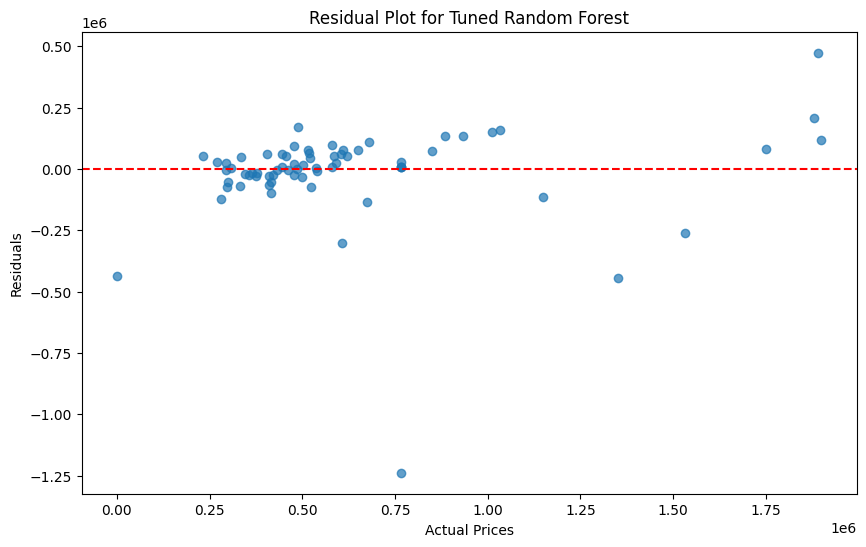

In [27]:

# Calculate residuals
residuals = y_test - best_rf_pred_test

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot for Tuned Random Forest")
plt.show()


## Feature Importance in Tuned Random Forest

The feature importance plot highlights which features contribute most to predicting `median_price`.

### Observations:
- **`rolling_avg_price`** is the most significant predictor, indicating that historical price trends strongly influence the model's predictions.
- **`transaction_density`** also plays a crucial role, showing that normalized transaction counts provide valuable insights.
- Other features like `sale_year`, `type_encoded`, and `transaction_count` have lower contributions.

This analysis helps identify which features are critical for predictions and may guide future feature engineering efforts.


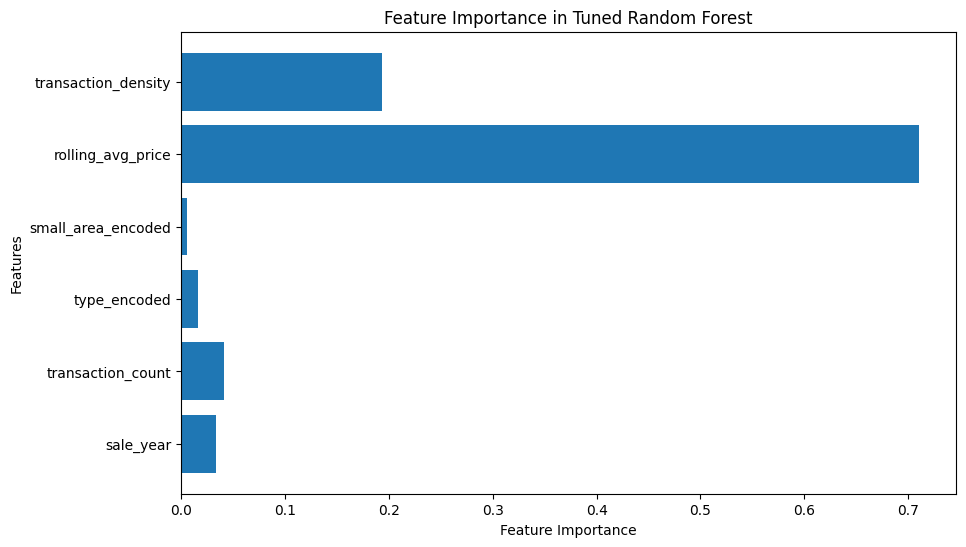

In [28]:
importances = best_rf.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Tuned Random Forest")
plt.show()


# Detailed Summary

## 1. Model Comparison

The table below compares the performance of the baseline (Linear Regression) and the tuned Random Forest model:

| **Model**              | **Test RMSE** | **Test R²** |
|-------------------------|---------------|-------------|
| Linear Regression       | 276,091       | 0.519       |
| Random Forest (Tuned)   | 197,573       | 0.754       |

### Key Observations:
1. The **Random Forest model** significantly outperforms Linear Regression:
   - RMSE is reduced by approximately 28%, indicating better accuracy.
   - R² increases from 51.9% to 75.4%, explaining more variance in `median_price`.

2. Random Forest's ability to capture nonlinear relationships and feature interactions makes it more suitable for this dataset.


## 4. Conclusion

The Random Forest model is the best-performing model for this project, providing significant improvements over Linear Regression.

### Achievements:
- Successfully predicted housing `median_price` using a combination of historical trends and transaction data.
- Enhanced accuracy by leveraging Random Forest's ability to handle nonlinear relationships and feature interactions.

### Next Steps:

1. **Deployment**:
   - Use the saved model for real-time predictions via a dashboard or API.
2. **Future Applications**:
   - Extend this analysis to other cities or regions to validate the model's generalizability.

The best-performing Random Forest model has been saved and is ready for deployment.
